In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import h5py

import os
from dotenv import load_dotenv
load_dotenv()

2023-08-25 23:41:13.684090: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 23:41:13.725138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-25 23:41:13.726222: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-25 23:41:14.992534: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


True

# Reading in esm2 embeddings

In [2]:
esm2_enzymes_30 = os.getenv("ESM2_ENZYMES_SPLIT_30")
esm2_non_enzymes = os.getenv("ESM2_NON_ENZYMES")

In [3]:
def get_ec_labels(path_to_enzyme_esm2: str, path_to_enzyme_splitX_csv) -> pd.DataFrame:
    """
    Adds a label representing the first main ec class (1-7) based on the ec number
    :param path_to_esm2: Absolute path to esm2 file
    :param path_to_enzyme_splitX_csv: Absolute path to splitX csv, which is needed for labeling
    :return: A dataframe containing the corresponding labels
    """
    with h5py.File(path_to_enzyme_esm2) as hdf_handle:
        headers = []
        embeddings = []

        for header, emb in hdf_handle.items():
            headers.append(header)
            embeddings.append(np.array(list(emb)))

    enzyme_csv = pd.read_csv(path_to_enzyme_splitX_csv, header=0, sep=',')

    labels = {} # dict with → header(id): label (1-7)


    for header in headers:
        number = enzyme_csv.loc[enzyme_csv["Entry"] == header,"EC number"]
        ec = int(number.iat[0][0])-1 # since we always start counting from 0
        labels[header] = ec

    header_label_tuples = [(header, labels[header]) for header in headers]

    # Create a new list of embeddings with labels
    embeddings_with_labels = []

    for header, emb in zip(headers, embeddings):
        label = next((label for h, label in header_label_tuples if h == header), None)
        if label is not None:
            embeddings_with_labels.append((header, label, emb))
    
    return embeddings_with_labels


### Creating X and y

In [ ]:
enzyme_csv = os.getenv("CSV100_ENZYMES")
esm2_enzymes = os.getenv("ESM2_ENZYMES_SPLIT_100")

labels = get_ec_labels(path_to_enzyme_esm2=esm2_enzymes, path_to_enzyme_splitX_csv=enzyme_csv)

X = []
y = []
for entry in labels:
    y.append(entry[1]) # append label (1-7)
    X.append(entry[2]) # append embedding

In [ ]:

print(len(X))
print(len(y))

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.countplot(x=y, palette="Set3")

# Add labels and title
plt.xlabel("Values")
plt.ylabel("Count")
plt.title("Count Plot of Values")

# Show the plot
plt.show()

In [ ]:
# Create a DataFrame
df = pd.DataFrame({"feature1":X, "label":y})


# Convert the lists in 'feature1' into separate columns using pd.DataFrame constructor
feature_columns = pd.DataFrame(df["feature1"].tolist(), columns=[f"feature_{i+1}" for i in range(2560)])

# Concatenate the feature columns with the original DataFrame
df = pd.concat([df.drop("feature1", axis=1), feature_columns], axis=1)

# Display the resulting DataFrame
print(df.head())


In [ ]:

X = df.drop('label', axis=1).values
y = df['label'].values



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
x_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)


In [ ]:
len(X_train[0])

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(units=256, activation='relu', input_shape=(2560,)))
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))  # Adding dropout for regularization
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=7, activation='softmax'))  # Using softmax for multi-class classification
# model.add(
#     tf.keras.layers.Dense(units=2560, activation="relu", input_shape=(2560,))
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=15, activation="relu")
# )
# 
# model.add(
#     tf.keras.layers.Dense(units=7, activation='softmax') # da classification
# )

model.compile(loss='categorical_crossentropy', optimizer='adam')


In [ ]:
model.fit(x=X_train, y=y_train_encoded, epochs=200, validation_data=(X_test, y_test_encoded))

<Axes: >

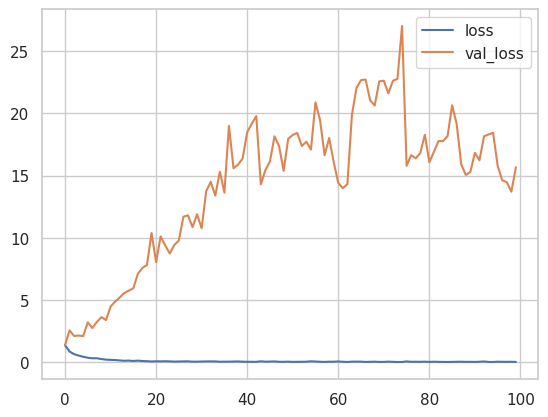

In [87]:
model_loss = pd.DataFrame(model.history.history)

model_loss.plot() # early stopping where plot diverges


In [88]:
predictions = np.argmax(model.predict(X_test), axis=-1) # for multi class classification (using softmax)

95/95 [==============================] - 0s 2ms/step


In [89]:
counter = 0
for x,y in zip(y_test,predictions):
    if x == y:
        counter+=1
print(counter)
print(len(y_test))

2308
3038


In [90]:
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

           0       0.84      0.67      0.75       408
           1       0.71      0.96      0.82      1241
           2       0.80      0.87      0.83       853
           3       0.81      0.11      0.20       225
           4       1.00      0.02      0.05       130
           5       0.97      0.48      0.64       125
           6       1.00      0.20      0.33        56

    accuracy                           0.76      3038
   macro avg       0.88      0.47      0.52      3038
weighted avg       0.79      0.76      0.72      3038


In [91]:
print(confusion_matrix(y_test, predictions))


[[ 275  101   32    0    0    0    0]
 [   8 1188   41    2    0    2    0]
 [   7   99  746    1    0    0    0]
 [  11  127   62   25    0    0    0]
 [   9   73   42    3    3    0    0]
 [   1   59    5    0    0   60    0]
 [  16   23    6    0    0    0   11]]


In [92]:
model.save("initial_ann_v1")

INFO:tensorflow:Assets written to: initial_ann_v1/assets


INFO:tensorflow:Assets written to: initial_ann_v1/assets
